In [1]:
from jax import numpy as jnp, random
from modax.data.burgers import burgers
import jax
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import ARDRegression

import numpy as np

# Train stridge

In [25]:
def TrainSTRidge(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them 
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]       

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY, rcond=None)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        w = STRidge(R,Ut,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    return w_best


def STRidge(X0, y, lam, maxit, tol, normalize = 2, print_results = False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse 
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0
    
    # Get the standard ridge esitmate
    if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y), rcond=None)[0]
    else: w = np.linalg.lstsq(X,y)[0]
    num_relevant = d
    biginds = np.where( abs(w) > tol)[0]
    
    # Threshold and continue
    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where( abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]
            
        # If nothing changes then stop
        if num_relevant == len(new_biginds): break
        else: num_relevant = len(new_biginds)
            
        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0: 
                #if print_results: print "Tolerance too high - all coefficients set below tolerance"
                return w
            else: break
        biginds = new_biginds
        
        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0: w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y), rcond=None)[0]
        else: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if len(biginds) != 0: 
        w[biginds] = np.linalg.lstsq(X[:, biginds],y, rcond=None)[0]
    
    if normalize != 0: 
        return np.multiply(Mreg,w)
    else: return w

# Without noise

In [6]:
# Making data

key = random.PRNGKey(0)
noise = 0.0

# Making data
x = jnp.linspace(-3, 4, 50)
t = jnp.linspace(0.5, 5.0, 20)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
y = burgers(x_grid, t_grid, 0.1, 1.0)

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)


X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_noisy = y + noise * jnp.std(y) * random.normal(key, y.shape)

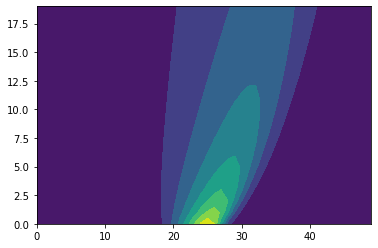

In [7]:
plt.contourf(y_noisy)

In [8]:
U, S, V = jnp.linalg.svd(y_noisy, full_matrices=False)

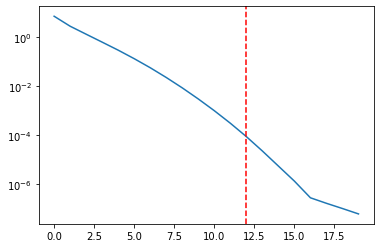

In [9]:
plt.semilogy(S)
plt.axvline(12, color='r', linestyle='--')

In [10]:
# Denoising with SVD
S_dom = jnp.diag(jax.ops.index_update(S, jax.ops.index[100:], 0))
y_denoised = (U @ S_dom @ V)

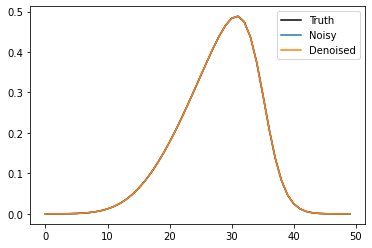

In [11]:
frame = 10
plt.plot(y[frame], 'k', label='Truth')
plt.plot(y_noisy[frame], label='Noisy')
plt.plot(y_denoised[frame], label='Denoised')

plt.legend()

In [30]:
# Calculating splines 
splines = jnp.stack([jnp.stack([UnivariateSpline(x, yi, k=5, s=0.0).derivatives(xi) for xi in x]) for yi in y_denoised])
u = splines[..., 0]

# TIme deriv is gradient of spline
dt = jnp.gradient(u, t[1]-t[0], axis=0).reshape(-1, 1)

# Derivs
derivs = splines[..., 1:-1].reshape(-1, 4)
derivs = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), derivs], axis=1)

# polynomial
poly = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), u.reshape(-1, 1), (u**2).reshape(-1, 1), (u**3).reshape(-1, 1)], axis=1)

# defining theta
theta = (jnp.expand_dims(poly, axis=-1) @ jnp.expand_dims(derivs, axis=-2)).reshape(derivs.shape[0], -1)

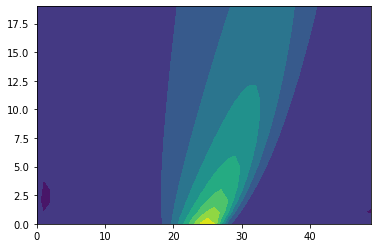

In [31]:
plt.contourf(u)

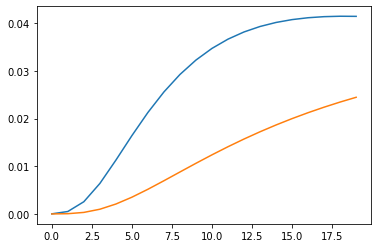

In [32]:
plt.plot((derivs[:, 1].reshape(x_grid.shape)[:, 10]))
plt.plot(u[:, 10])

In [33]:
# SBL results 
SBL = ARDRegression(fit_intercept=False)
SBL.fit(theta, dt.squeeze())

eq_SBL = SBL.coef_

In [34]:
SBL.alpha_

2287.0901522450254

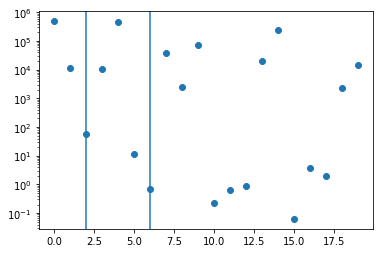

In [35]:
plt.semilogy(SBL.lambda_, 'o')
plt.axvline(2)
plt.axvline(6)

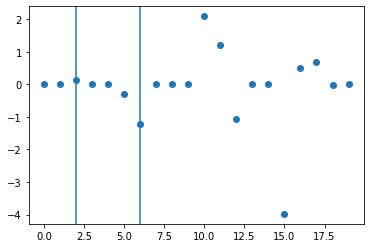

In [36]:
plt.plot(SBL.coef_, 'o')
plt.axvline(2)
plt.axvline(6)

In [37]:
eq_sindy = TrainSTRidge(theta, dt, lam=1e-2, d_tol=0.1)

In [38]:
print(eq_sindy)

[[ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.09298549+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [-0.79731885+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]]


In [39]:
print(eq_SBL[:, None])

[[ 0.        ]
 [ 0.        ]
 [ 0.13441745]
 [ 0.        ]
 [ 0.        ]
 [-0.29101172]
 [-1.20457465]
 [ 0.        ]
 [ 0.02014377]
 [ 0.        ]
 [ 2.09009509]
 [ 1.21840791]
 [-1.04968821]
 [ 0.        ]
 [ 0.        ]
 [-3.97924304]
 [ 0.51029997]
 [ 0.70012295]
 [-0.02035143]
 [ 0.        ]]


# With noise - 10%

In [40]:
# Making data

key = random.PRNGKey(0)
noise = 0.10

# Making data
x = jnp.linspace(-3, 4, 50)
t = jnp.linspace(0.5, 5.0, 20)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
y = burgers(x_grid, t_grid, 0.1, 1.0)

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)


X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_noisy = y + noise * jnp.std(y) * random.normal(key, y.shape)

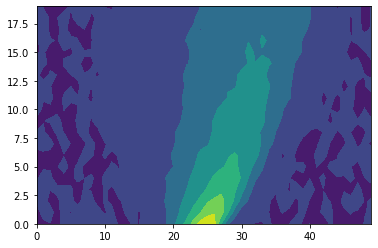

In [41]:
plt.contourf(y_noisy)

In [42]:
U, S, V = jnp.linalg.svd(y_noisy, full_matrices=False)

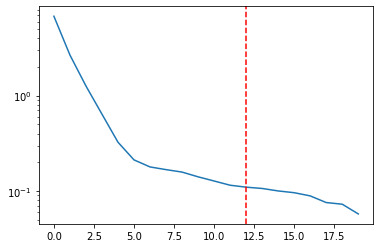

In [43]:
plt.semilogy(S)
plt.axvline(12, color='r', linestyle='--')

In [44]:
# Denoising with SVD
S_dom = jnp.diag(jax.ops.index_update(S, jax.ops.index[5:], 0))
y_denoised = (U @ S_dom @ V)

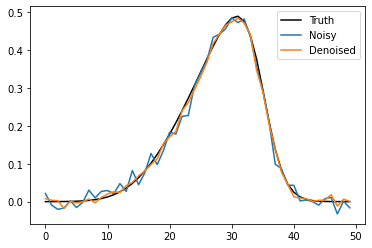

In [45]:
frame = 10
plt.plot(y[frame], 'k', label='Truth')
plt.plot(y_noisy[frame], label='Noisy')
plt.plot(y_denoised[frame], label='Denoised')

plt.legend()

In [46]:
# Calculating splines 
splines = jnp.stack([jnp.stack([UnivariateSpline(x, yi, k=5, s=0.0).derivatives(xi) for xi in x]) for yi in y_denoised])
u = splines[..., 0]

# TIme deriv is gradient of spline
dt = jnp.gradient(u, t[1]-t[0], axis=0).reshape(-1, 1)

# Derivs
derivs = splines[..., 1:-1].reshape(-1, 4)
derivs = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), derivs], axis=1)

# polynomial
poly = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), u.reshape(-1, 1), (u**2).reshape(-1, 1), (u**3).reshape(-1, 1)], axis=1)

# defining theta
theta = (jnp.expand_dims(poly, axis=-1) @ jnp.expand_dims(derivs, axis=-2)).reshape(derivs.shape[0], -1)

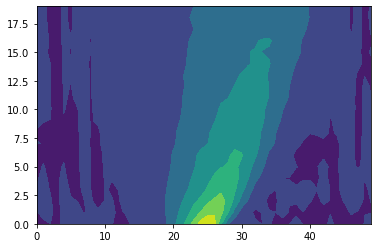

In [47]:
plt.contourf(u)

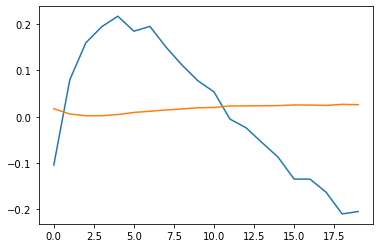

In [48]:
plt.plot((derivs[:, 1].reshape(x_grid.shape)[:, 10]))
plt.plot(u[:, 10])

In [49]:
# SBL results 
SBL = ARDRegression(fit_intercept=False)
SBL.fit(theta, dt.squeeze())

eq_SBL = SBL.coef_

In [50]:
SBL.alpha_

179.39380566088175

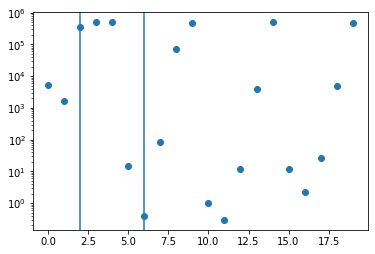

In [51]:
plt.semilogy(SBL.lambda_, 'o')
plt.axvline(2)
plt.axvline(6)

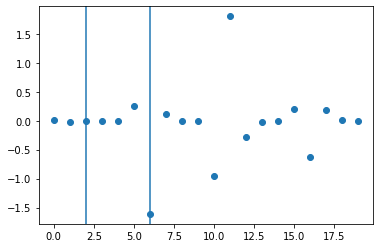

In [52]:
plt.plot(SBL.coef_, 'o')
plt.axvline(2)
plt.axvline(6)

In [58]:
eq_sindy = TrainSTRidge(theta, dt, lam=1e-2, d_tol=0.1)

In [59]:
print(eq_sindy)

[[ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [-0.58878261+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]]


In [60]:
print(eq_SBL[:, None])

[[ 0.01347561]
 [-0.02313688]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.25427856]
 [-1.61061425]
 [ 0.10721146]
 [ 0.        ]
 [ 0.        ]
 [-0.96189343]
 [ 1.80465581]
 [-0.28176744]
 [-0.01561469]
 [ 0.        ]
 [ 0.20786218]
 [-0.61916682]
 [ 0.19127908]
 [ 0.01375076]
 [ 0.        ]]


# With noise - 20%

In [61]:
# Making data

key = random.PRNGKey(0)
noise = 0.20

# Making data
x = jnp.linspace(-3, 4, 50)
t = jnp.linspace(0.5, 5.0, 20)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
y = burgers(x_grid, t_grid, 0.1, 1.0)

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)


X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_noisy = y + noise * jnp.std(y) * random.normal(key, y.shape)

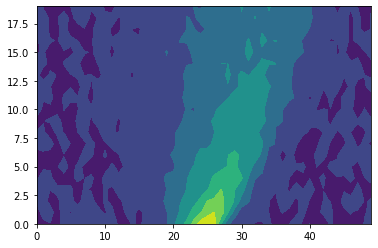

In [62]:
plt.contourf(y_noisy)

In [63]:
U, S, V = jnp.linalg.svd(y_noisy, full_matrices=False)

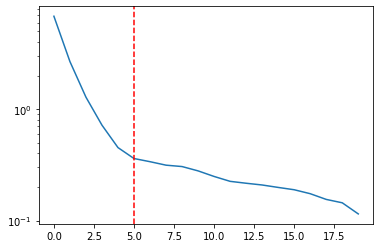

In [67]:
plt.semilogy(S)
plt.axvline(5, color='r', linestyle='--')

In [71]:
# Denoising with SVD
S_dom = jnp.diag(jax.ops.index_update(S, jax.ops.index[5:], 0))
y_denoised = (U @ S_dom @ V)

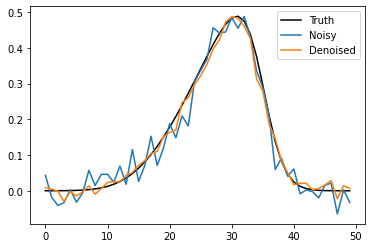

In [72]:
frame = 10
plt.plot(y[frame], 'k', label='Truth')
plt.plot(y_noisy[frame], label='Noisy')
plt.plot(y_denoised[frame], label='Denoised')

plt.legend()

In [73]:
# Calculating splines 
splines = jnp.stack([jnp.stack([UnivariateSpline(x, yi, k=5, s=0.0).derivatives(xi) for xi in x]) for yi in y_denoised])
u = splines[..., 0]

# TIme deriv is gradient of spline
dt = jnp.gradient(u, t[1]-t[0], axis=0).reshape(-1, 1)

# Derivs
derivs = splines[..., 1:-1].reshape(-1, 4)
derivs = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), derivs], axis=1)

# polynomial
poly = jnp.concatenate([jnp.ones((derivs.shape[0], 1)), u.reshape(-1, 1), (u**2).reshape(-1, 1), (u**3).reshape(-1, 1)], axis=1)

# defining theta
theta = (jnp.expand_dims(poly, axis=-1) @ jnp.expand_dims(derivs, axis=-2)).reshape(derivs.shape[0], -1)

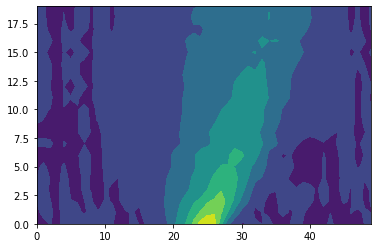

In [74]:
plt.contourf(u)

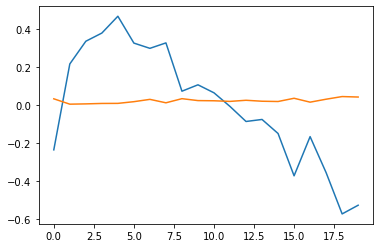

In [75]:
plt.plot((derivs[:, 1].reshape(x_grid.shape)[:, 10]))
plt.plot(u[:, 10])

In [76]:
# SBL results 
SBL = ARDRegression(fit_intercept=False)
SBL.fit(theta, dt.squeeze())

eq_SBL = SBL.coef_

In [77]:
SBL.alpha_

95.98157112045742

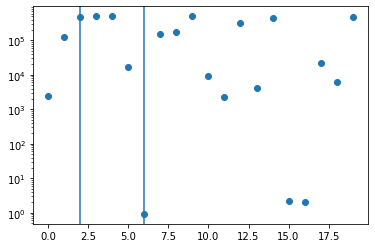

In [78]:
plt.semilogy(SBL.lambda_, 'o')
plt.axvline(2)
plt.axvline(6)

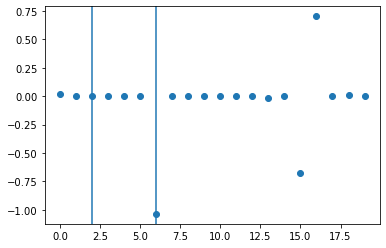

In [79]:
plt.plot(SBL.coef_, 'o')
plt.axvline(2)
plt.axvline(6)

In [80]:
eq_sindy = TrainSTRidge(theta, dt, lam=1e-2, d_tol=0.1)

In [81]:
print(eq_sindy)

[[ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [-0.495206+0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]
 [ 0.      +0.j]]


In [82]:
print(eq_SBL[:, None])

[[ 1.97755062e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.03644475e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.76492173e-04]
 [ 4.95272412e-04]
 [ 0.00000000e+00]
 [-1.54230793e-02]
 [ 0.00000000e+00]
 [-6.72287671e-01]
 [ 7.03908230e-01]
 [ 0.00000000e+00]
 [ 1.26526700e-02]
 [ 0.00000000e+00]]
